#### Дипломный проект
#### Студент Татур А.А.
#### Дата - 27.04.2023
# __________________________________________________________________
#### Цель работы - создать ML модель для проведения измерения зрачка (пупиллограмма) во входящем потоковом видео, представляющего собой видеозапись всего лица
#### Сет - NVGaze от Nvidia
#### Модель - конволюционная по типу VGG16
# __________________________________________________________________
#### Суть работы:
#### 1. в имеющемся датасете, используя библиотеку OpenCV при помощи работы с трешхолдами мы выбираем на изображениях только область зрачка и получаем ее координаты и радиус - вектор [X,Y,R].\
#### 2. Далее, при помощи сверточной нейронной сети мы делаем предикт этого вектора. 
#### 3. На входящем видеоролике мы выделяем область лица и глаза (в данной работе пупиллограмма делается только на левом глазу) при помощи готовой библиотеки от Google - MediaPipe. И загружая в нашу модель полученную вырезанную часть лица (радужку) получаем предикт вектора [X,Y,R]

# Часть 1 - Подготовка датасета

##### Необходимые импорты

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns


pd.set_option('display.max_rows', 30)

##### Исходный csv файл со ссылками к исходным изображениям.

In [4]:
df = pd.read_csv('eyes.csv')

In [5]:
df

,imagefile,eye
0,D:\Eyes dataset\13\000001.jpg,L
1,D:\Eyes dataset\13\000002.jpg,L
2,D:\Eyes dataset\13\000003.jpg,L
3,D:\Eyes dataset\13\000004.jpg,L
4,D:\Eyes dataset\13\000005.jpg,L
...,...,...
336166,D:\Eyes dataset\17\070457.jpg,R
336167,D:\Eyes dataset\17\070458.jpg,R
336168,D:\Eyes dataset\17\070459.jpg,R
336169,D:\Eyes dataset\17\070460.jpg,R


#### Исходное изображение
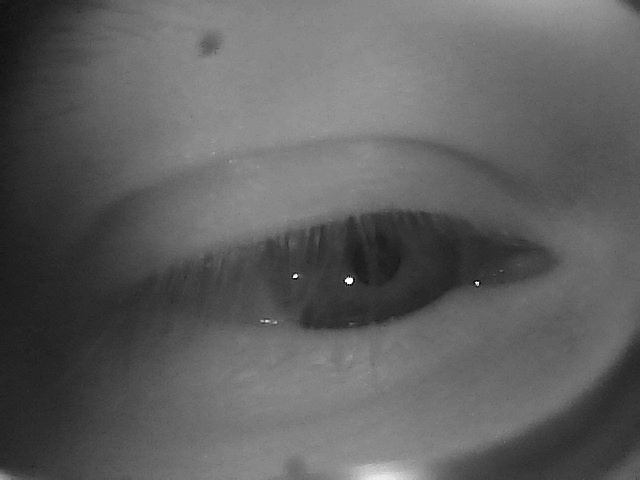

#### Проведем определение положения зрачка на исходных изобржениях, используя работу с трешхолдами. Получим координаты центра зрачка и его радиус. Для визуальной оценки также сохраним копию изображения с выделенным зрачком

In [ ]:
df_03_normalized_set_pupils_marked = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    path = df.iloc[x]['path']
    side = df.iloc[x]['eye']
    
    image = cv2.imread(path)
    
    row, col, _ = image.shape #Получаем ширину и высоту выделенного фрагмента
    gray_roi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Конверция в серые тона
    gray_roi = cv2.GaussianBlur (gray_roi, (33, 33), 0) #Сглаживаем изображение
    __, threshold = cv2.threshold (gray_roi, 40, 255, cv2.THRESH_BINARY) #Отсекаем по трэшхолду 
    contours, __ = cv2.findContours (threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #Используем функцию для поиска контуров
                                                                                        #объектов после выделения их по порогу
    contours = sorted (contours, key = lambda x: cv2.contourArea(x), reverse = True)    #Сортируем все контуры от большего к 
    
    try:
        os.remove(path[:-3] + 'jpeg')
    except:
        None
        
    for cnt in contours:
        if cv2.contourArea(cnt)>400 and cv2.contourArea(cnt)<15000: #оставляем по площади только то, что на зрачок похоже
            (x,y), r = cv2.minEnclosingCircle(cnt)
            x=int(x)
            y=int(y)
            r = int(r)
            
            cv2.circle (image, (x,y), r, (255,255,0), 2)
            filename_png = path[:-3] + 'jpeg'
            cv2.imwrite(filename_png, image)
            
            data = pd.DataFrame({'eye':     [str(side)],
                                 'path':    [str(path)],
                                 'im_h(y)': [int(row)],
                                 'im_w(x)': [int(col)],
                                 'pupil_x': [int(x)],
                                 'pupil_y': [int(y)],
                                 'pupil_r': [int(r)] })
            
            df_03_normalized_set_pupils_marked = pd.concat([df_03_normalized_set_pupils_marked,data], axis=0);
            
df_03_normalized_set_pupils_marked.to_csv('df_03_normalized_set_pupils_marked.csv',
              index=False)

##### Вид изображения с выделенным зрачком

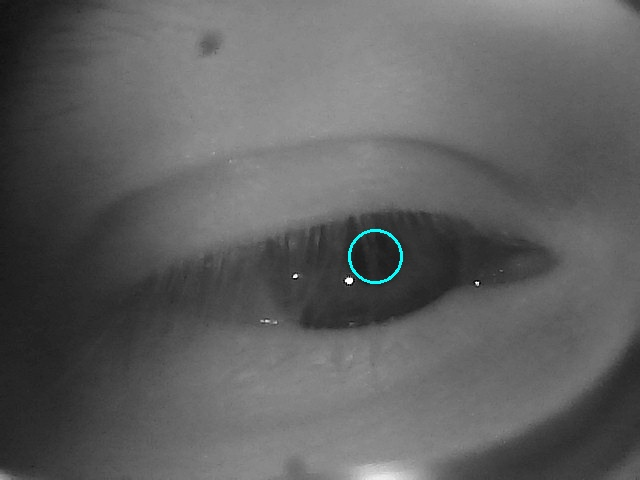

#### Вид таблицы после завершения работы алгоритма

In [226]:
df = pd.read_csv ('df_03_normalized_set_pupils_marked.csv')
df

,eye,path,im_h(y),im_w(x),pupil_x,pupil_y,pupil_r
0,L,D:\Eyes dataset\01.Normalized\13\000001.jpg,480,640,375,256,26
1,L,D:\Eyes dataset\01.Normalized\13\000002.jpg,480,640,375,257,26
2,L,D:\Eyes dataset\01.Normalized\13\000003.jpg,480,640,375,257,27
3,L,D:\Eyes dataset\01.Normalized\13\000004.jpg,480,640,375,255,27
4,L,D:\Eyes dataset\01.Normalized\13\000005.jpg,480,640,375,256,26
...,...,...,...,...,...,...,...
330578,R,D:\Eyes dataset\01.Normalized\17\070457.jpg,480,640,327,162,26
330579,R,D:\Eyes dataset\01.Normalized\17\070458.jpg,480,640,328,161,26
330580,R,D:\Eyes dataset\01.Normalized\17\070459.jpg,480,640,328,161,25
330581,R,D:\Eyes dataset\01.Normalized\17\070460.jpg,480,640,327,161,25


#### Проведем очистку сета, выбросим откровенные выбросы по диаметру, а также дубликаты (изображения где найдено 2 и более зрачка)

In [227]:
##### Выкинем дубликаты. Те изображения, где было найдено несколько центров.
df.drop(df[df.path.duplicated(keep=False)].index, inplace=True)

<AxesSubplot: >

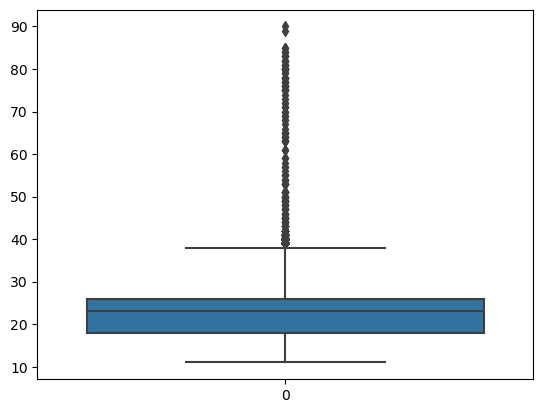

In [229]:
##### Проверим распределение по размеру зрачка в сете.
sns.boxplot(df.pupil_r)

In [255]:
df.drop(df[df.pupil_r>38].index, inplace=True)

In [257]:
df.to_csv('df_04_normalized_set_pupils_marked_wo_outliers.csv',
              index=False)

##### Отталкиваясь от центра зрачка выделим радужку. Как формулу используем эмпирически подобранные параметры: от координат зрачка захватим по 108 пикселей слева и справа, сверху 96 пикселей, снизу 120

In [280]:
df=pd.read_csv('df_04_normalized_set_pupils_marked_wo_outliers.csv')

In [304]:
df_05_normalized_iris_set = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    side = df.iloc[x]['eye']
    path = df.iloc[x]['path']
    pupil_x=df.iloc[x]['pupil_x']
    pupil_y=df.iloc[x]['pupil_y']
    
    image = cv2.imread(path)
        
    name = str(path).split('\\')[-1]
    collection_name = str(path).split('\\')[-2]
    
    new_path = 'D:\\Eyes dataset\\02.Iris_set\\' + collection_name + '\\' + name
    
    try:
        os.remove(new_path)
    except:
        None 
    
    h,w,_ = image.shape
    corr_h = 120# int(0.2*h)
    corr_w = 120# int(0.2*w)

    y1=pupil_y-int(0.8*corr_h)
    y2=pupil_y+corr_h
    x1=pupil_x-int(0.9*corr_w)
    x2=pupil_x+int(0.9*corr_w)

    iris_roi = image[y1:y2, 
                     x1:x2]
    
    cv2.imwrite(new_path, iris_roi)
        
    data = pd.DataFrame({'eye':[str(side)],
                         'path': [str(new_path)]})      
    
    df_05_normalized_iris_set = pd.concat([df_05_normalized_iris_set, data], axis=0);
            
df_05_normalized_iris_set.to_csv('df_05_normalized_iris_set.csv',
                                  index=True)

100%|██████████| 282633/282633 [1:26:30<00:00, 54.46it/s]  


##### Вид изображения после выделения радужки

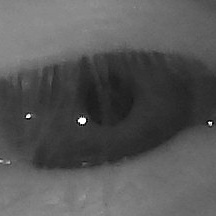

##### Итоговый датасет. Вычисляем радиус и коорданты зрачка в сете только с радужками.

In [305]:
df = pd.read_csv ('df_05_normalized_iris_set.csv')

In [306]:
df

,Unnamed: 0,eye,path
0,0,L,D:\Eyes dataset\02.Iris_set\13\000001.jpg
1,0,L,D:\Eyes dataset\02.Iris_set\13\000002.jpg
2,0,L,D:\Eyes dataset\02.Iris_set\13\000003.jpg
3,0,L,D:\Eyes dataset\02.Iris_set\13\000004.jpg
4,0,L,D:\Eyes dataset\02.Iris_set\13\000005.jpg
...,...,...,...
282628,0,R,D:\Eyes dataset\02.Iris_set\17\070457.jpg
282629,0,R,D:\Eyes dataset\02.Iris_set\17\070458.jpg
282630,0,R,D:\Eyes dataset\02.Iris_set\17\070459.jpg
282631,0,R,D:\Eyes dataset\02.Iris_set\17\070460.jpg


In [313]:
df_06_normalized_iris_set_w_pupils = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    path = df.iloc[x]['path']
    side = df.iloc[x]['eye']
    
    image = cv2.imread(path)
    row, col, _ = image.shape #Получаем ширину и высоту выделенного фрагмента
    gray_roi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Конверция в серые тона
    gray_roi = cv2.GaussianBlur (gray_roi, (33, 33), 0) #Сглаживаем изображение
    __, threshold = cv2.threshold (gray_roi, 40, 255, cv2.THRESH_BINARY) #Отсекаем по трэшхолду 
    contours, __ = cv2.findContours (threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #Используем функцию для поиска контуров
                                                                                        #объектов после выделения их по порогу
    contours = sorted (contours, key = lambda x: cv2.contourArea(x), reverse = True)    #Сортируем все контуры от большего к 
    
    try:
        os.remove(path[:-3] + 'jpeg')
    except:
        None
        
    for cnt in contours:
        if cv2.contourArea(cnt)>400 and cv2.contourArea(cnt)<15000: #оставляем по площади только то, что на зрачок похоже
            (x,y), r = cv2.minEnclosingCircle(cnt)
            x=int(x)
            y=int(y)
            r = int(r)
            
            cv2.circle (image, (x,y), r, (255,255,0), 2)
            filename_png = path[:-3] + 'jpeg'
            cv2.imwrite(filename_png, image)
            
            data = pd.DataFrame({'eye':     [str(side)],
                                 'path':    [str(path)],
                                 'im_h(y)': [int(row)],
                                 'im_w(x)': [int(col)],
                                 'pupil_x': [int(x)],
                                 'pupil_y': [int(y)],
                                 'pupil_r': [int(r)] })
            
            df_06_normalized_iris_set_w_pupils = pd.concat([df_06_normalized_iris_set_w_pupils,data], axis=0);
            
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv',
                                          index=False)

100%|██████████| 282633/282633 [1:18:12<00:00, 60.23it/s]


##### Вид изображения после выделения радужки и разметки зрачка

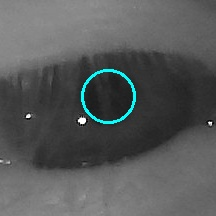

#### Cнова проводим очистку данных

In [314]:
df_06_normalized_iris_set_w_pupils = pd.read_csv('df_06_normalized_iris_set_w_pupils.csv')

In [320]:
dupl = df_06_normalized_iris_set_w_pupils[df_06_normalized_iris_set_w_pupils['path'].duplicated (keep=False)].index
df_06_normalized_iris_set_w_pupils.drop(dupl, inplace=True)
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv', index=False)

<AxesSubplot: >

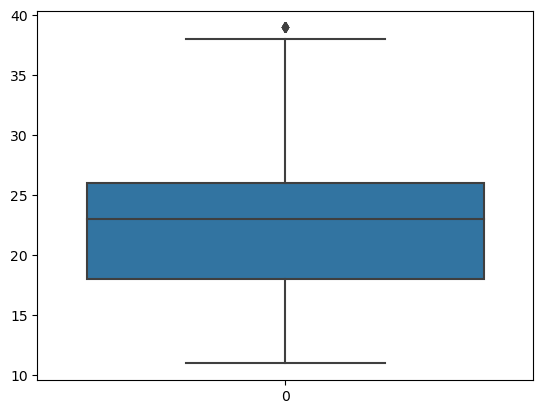

In [338]:
sns.boxplot(df_06_normalized_iris_set_w_pupils.pupil_r)

<AxesSubplot: xlabel='pupil_r', ylabel='Count'>

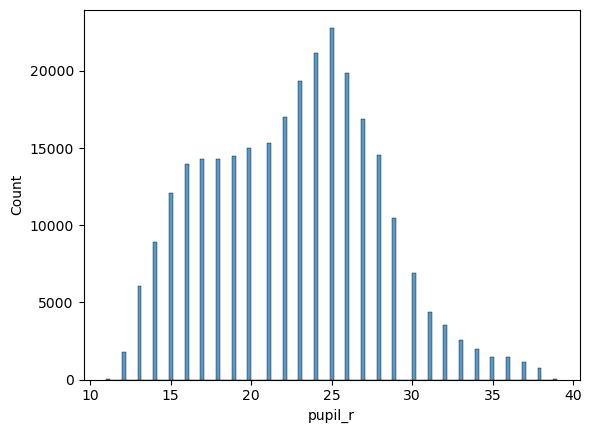

In [343]:
sns.histplot(df_06_normalized_iris_set_w_pupils.pupil_r)

In [354]:
df_06_normalized_iris_set_w_pupils[df_06_normalized_iris_set_w_pupils.pupil_r>=38]

,eye,path,im_h(y),im_w(x),pupil_x,pupil_y,pupil_r
148,L,D:\Eyes dataset\02.Iris_set\13\000306.jpg,216,216,108,96,38
155,L,D:\Eyes dataset\02.Iris_set\13\000313.jpg,216,216,108,96,38
158,L,D:\Eyes dataset\02.Iris_set\13\000316.jpg,216,216,108,96,38
159,L,D:\Eyes dataset\02.Iris_set\13\000317.jpg,216,216,108,96,38
160,L,D:\Eyes dataset\02.Iris_set\13\000318.jpg,216,216,107,96,38
...,...,...,...,...,...,...,...
182901,L,D:\Eyes dataset\02.Iris_set\16\023760.jpg,216,216,108,96,38
184585,R,D:\Eyes dataset\02.Iris_set\16\026238.jpg,216,215,108,96,38
187643,L,D:\Eyes dataset\02.Iris_set\16\030708.jpg,216,213,109,97,38
210038,R,D:\Eyes dataset\02.Iris_set\16\060077.jpg,216,213,108,97,38


In [352]:
df_06_normalized_iris_set_w_pupils.drop([196967,210620,215005], axis=0, inplace=True)

In [356]:
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv', index=False)

# Часть 2 - Обучение модели.

#### Необходимые импорты

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, AveragePooling2D,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model

import gc
pd.set_option('display.max_rows', 30)

In [ ]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### Создаем обучающие наборы

In [ ]:
df = pd.read_csv ('df_06_normalized_iris_set_w_pupils.csv')

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=43) #

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
TARGET_SIZE = (216,216)
COLOR_MODE = "grayscale" #grayscale
BATCH_SIZE = 10

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

#### Создаем архитектуру модели

In [ ]:
#### Создаем архитектуру модели
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(216,216,1)))
model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(1024, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(1024, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(2000, activation='relu'))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(Dense(2000, activation='relu'))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(Dense(3, activation='relu')
               
model_conv.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [ ]:
checkpoint_cb_conv = ModelCheckpoint("own_model-LR-216_216_just_iris.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [ ]:
history = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=50)

In [ ]:
test_val_graph(history, 'mae', 'val_mae')

# Часть 3 - Применение полученного сета

#### Необходимые импорты

In [ ]:
import mediapipe as mp
import cv2
import numpy as np
from tensorflow.keras.models import load_model
mp_face_mesh = mp.solutions.face_mesh

#### Загружаем модель

In [ ]:
model = load_model ('model\own_model-LR-216_216_just_iris.h5')
MODEL_X=216
MODEL_Y=216
MODEL_DEPTH=1

#### Функция по выделению только левой радужки

In [ ]:
def left_iris_roi(mesh_p, h,w):
    
    LEFT_IRIS_LEFT_CORNER = 474 ####LEFT
    LEFT_IRIS_RIGHT_CORNER = 476 ####RIGHT        
    LEFT_IRIS_UPPER_CORNER = 475 ####UP
    LEFT_IRIS_BOTTOM_CORNER = 477 ###DOWN
    
    CORR_Y = int(0.01*h) ### Корректирующие коэффициенты
    CORR_X = int(0.01*w) ###

    from_y_left = mesh_p[LEFT_IRIS_UPPER_CORNER][1] - CORR_Y
    to_y_left = mesh_p[LEFT_IRIS_BOTTOM_CORNER][1] + CORR_Y
    
    from_x_left = mesh_p[LEFT_IRIS_RIGHT_CORNER][0] - CORR_X
    to_x_left = mesh_p[LEFT_IRIS_LEFT_CORNER][0] + CORR_X
    
    return from_y_left, to_y_left, from_x_left, to_x_left

#### Функция предикта

In [ ]:
def predict(image, 
            model_x, 
            model_y,
            model_depth,
            verbose=0):
    
    image = image/255
    image = image.reshape(1, model_x, model_y, model_depth)
    x, y, r = model.predict(image, verbose=verbose).astype(int)[0]
    
    return x,y,r

#### Функция, реализующая пупиллограмму

In [ ]:
def pupillogram(FILE_NAME):
    
    print ('... инициализируем захват зрачка')
    RADIUS_CHANGE = []
    cap = cv2.VideoCapture(FILE_NAME)
        
    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:
        
        print ('... начинаем измерения зрачка')
        while cap.isOpened():
            success, image = cap.read()
        
            if not success:### Проверяем окончание ролика
                break 
                
            h,w,_ = np.shape(image)   
           
                ### Детекция точек
            results = face_mesh.process(image)
        
            if results.multi_face_landmarks:
                ### Переводим координаты из относительных в абслютные значения
                mesh_p = np.array([np.multiply([p.x, p.y], [w,h]).astype(int) for p in results.multi_face_landmarks[0].landmark])
            else:
                print ("Лицо не найдено")
            y1,y2,x1,x2 = left_iris_roi(mesh_p, h,w) ### Получаем координаты радужки
            roi_left = image [y1:y2,x1:x2]
            
                ##### Получаем предикт
            x,y,r = predict(roi_left,
                                 model_x=MODEL_X, 
                                 model_y=MODEL_Y,
                                 model_depth=MODEL_DEPTH)
                
                
            RADIUS_CHANGE.append(r) #### Массив с изменениями радиуса зрачка
                
            cv2.circle (corrected_img, (x,y), r, (255,255,0), 1)
            cv2.putText(corrected_img, 'Radius - ' + str(r) , (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                                        0.5, (255, 0, 0), 2, cv2.LINE_AA)
            
            cv2.imshow ('Full face', image)
            cv2.imshow ('Left Eye', corrected_img)
            
            key=cv2.waitKey(30)
            if key==27:
                break
            
    cap.release()
    cv2.destroyAllWindows()
    print ('... работа модуля завершена\n')
    return RADIUS_CHANGE

In [ ]:
FILE = 'video\\temp.avi'
pupillogram(FILE)

##### Результат работы

##### Исходное видео
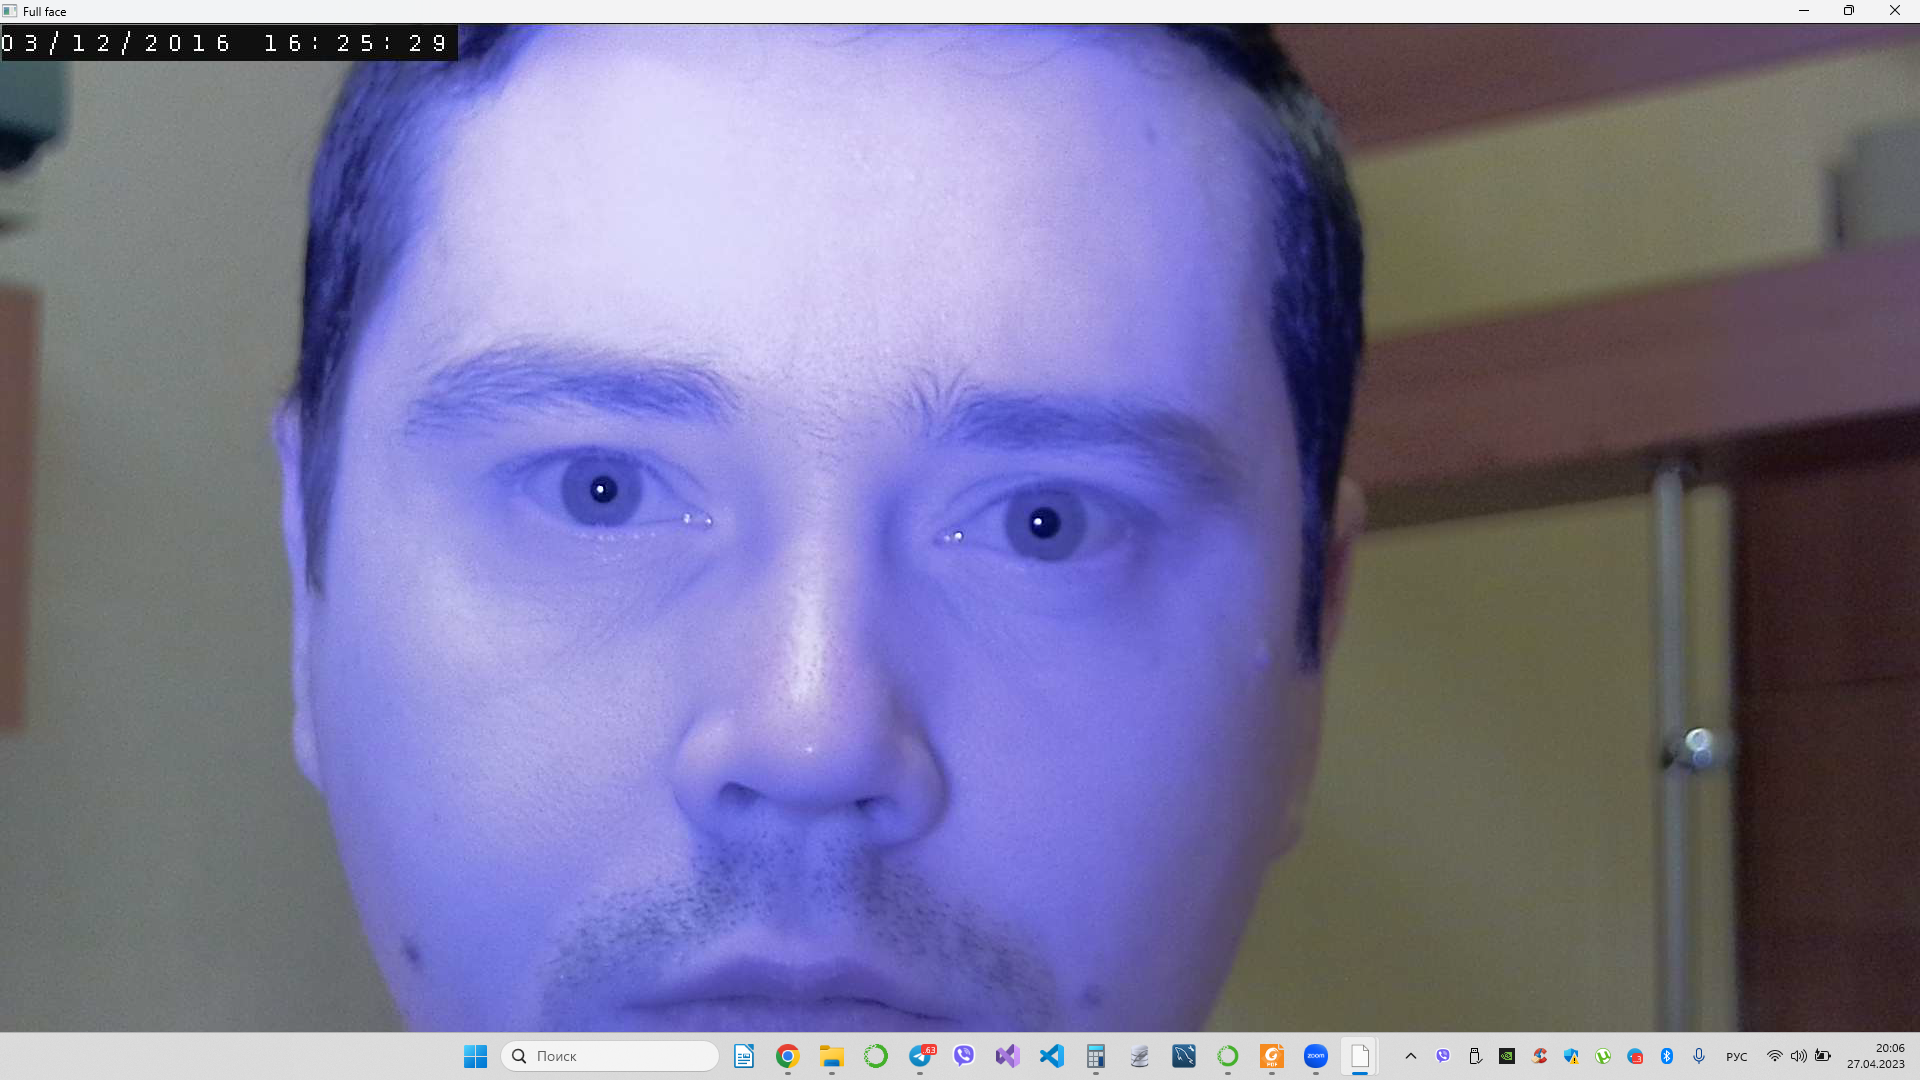

#### Выделенный зрачкок и его радиус(в пикселях)

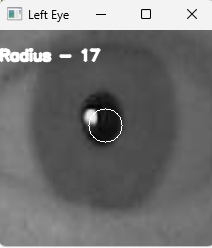



#### Выводы:

Данный подход демонстрирует применение нейронных сетей для детекции объектов на видео. 

Для дальнейшего повышения точности работы модели необходимо проводить дальнейшую работу с данными:
1. увеличить его разнообразия, т.к. все изображения в использованном наборе выполнены в одинаковых, "рафинированных" условиях, которые редко будут встречаться в жизни.
2. Провести ручную глубокую очисту, поскольку подход по отсечению выбросов и дубликатов не позволяет полностью выкинуть все неверно размеченые изображения по трешхолду. Однако выполнить это в одиночку за короткий срок (в сете около 270к изображений) проблематично